<div style="background-color: darkred; padding: 10px; color: white;">

# Train Soma Classifier

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Load Training Data
    
</div>

### Imports

In [1]:
from random import sample
from scipy.optimize import OptimizeWarning

import ast
import os
import warnings

from aind_exaspim_soma_detection.utils import data_util, img_util, util
from aind_exaspim_soma_detection.machine_learning import data_handling
from aind_exaspim_soma_detection.machine_learning.data_handling import ProposalDataset

warnings.filterwarnings("ignore", category=OptimizeWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

%matplotlib inline

### Initializations

In [2]:
# Parameters
anisotropy = [0.748, 0.748, 1.0]
multiscale = 1
patch_shape = (102, 102, 102)

# Paths
img_lookup_path =  "/root/capsule/data/exaspim_image_prefixes.json"
smartsheet_path = "/root/capsule/data/Neuron_Reconstructions.xlsx"
exaspim_soma_path = "/root/capsule/data/exaspim_somas_2024"

### Load Data

In [3]:
# SmartSheet Data
smartsheet_data = data_util.fetch_smartsheet_somas(
    smartsheet_path,
    img_lookup_path,
    multiscale,
)

# ExaSPIM Data
exapsim_data = data_util.fetch_exaspim_somas_2024(
    exaspim_soma_path,
    img_lookup_path,
    multiscale,
)

# Additional Examples
ignore = data_util.load_examples("/root/capsule/data/ignore.txt")
test_positives = data_util.load_examples("/root/capsule/data/test_positives.txt")
test_negatives = data_util.load_examples("/root/capsule/data/test_negatives.txt")

/opt/conda/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
100%|██████████| 31/31 [01:04<00:00,  2.08s/it]


### Create Dataset

In [4]:
# Initialize Dataset
dataset = ProposalDataset(patch_shape, transform=True)
for proposals_tuple in smartsheet_data + exapsim_data:
    dataset.ingest_proposals(*proposals_tuple)

# Remove Testing Examples
keys = list(dataset.proposals.keys())
test_examples = set(test_positives + test_negatives)
for key in keys:
    if key in test_examples or key in ignore:
        dataset.remove_proposal(key, epsilon=10)

# Report Dataset Specs
print("# Examples:", len(dataset))
print("# Positive Examples", dataset.n_positives())
print("# Negative Examples", dataset.n_negatives())

# Examples: 2141
# Positive Examples 1331
# Negative Examples 810


### Visualize Training Example

Example ID: ('653158', (14295, 7150, 6837))
Label: 1


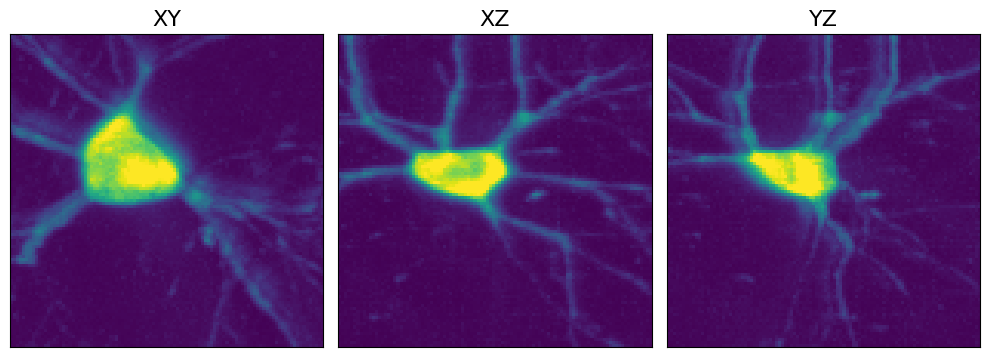

In [5]:
key = util.sample_once(list(dataset.proposals.keys()))
print("Example ID:", key)
print("Label:", dataset.proposals[key])
dataset.visualize_proposal(key)

### Visualize Augmented Training Example

Example ID: ('737563', (19712, 3040, 6680))
Label: 0


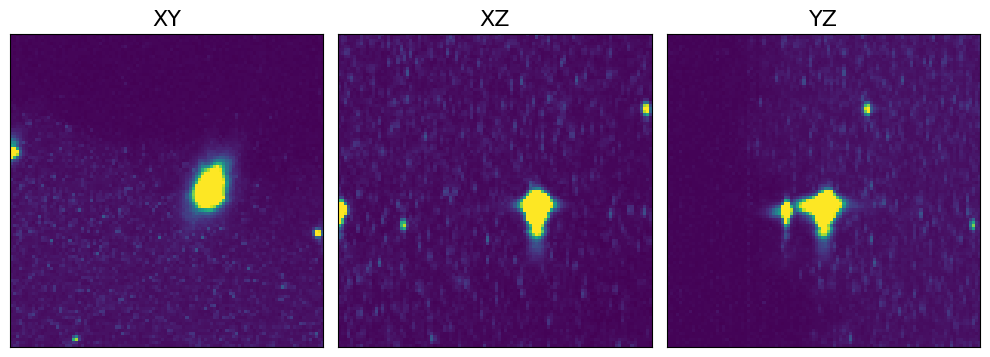

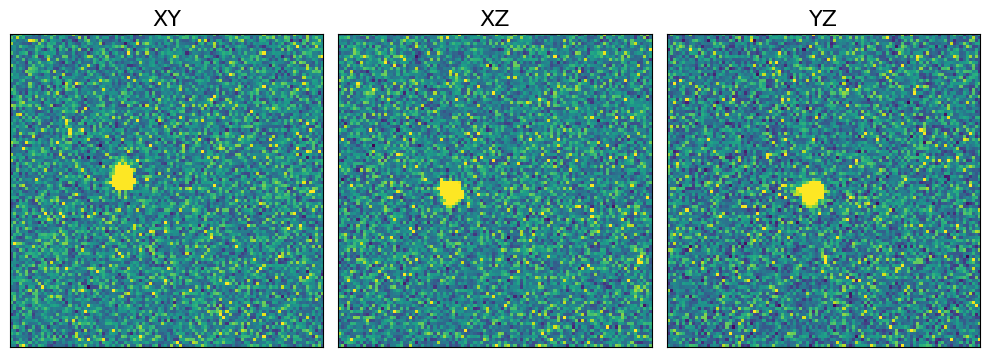

In [6]:
key = util.sample_once(list(dataset.proposals.keys()))
print("Example ID:", key)
print("Label:", dataset.proposals[key])
dataset.visualize_augmented_proposal(key)

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Train Model
    
</div>

### Imports

In [7]:
from datetime import datetime

from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


from aind_exaspim_soma_detection.machine_learning import trainer
from aind_exaspim_soma_detection.machine_learning.data_handling import MultiThreadedDataLoader
from aind_exaspim_soma_detection.machine_learning.models import Fast3dCNN
from aind_exaspim_soma_detection.utils import ml_util

### Initialize Datasets

In [8]:
# Train-Validation Split - Negative examples
train_negatives, valid_negatives = ml_util.split_train_validation(
    dataset.get_negatives()
)

# Train-Validation Split - Positive examples
n_negatives = len(train_negatives) + len(valid_negatives)
positives_keys = sample(dataset.get_positives().keys(), n_negatives)
positives = dict({k: dataset.proposals[k] for k in positives_keys})
train_positives, valid_positives = ml_util.split_train_validation(positives)

# Train-Validation Datasets
train_dataset = data_handling.init_subdataset(
    dataset, train_positives, train_negatives, patch_shape, True
)
valid_dataset = data_handling.init_subdataset(
    dataset, valid_positives, valid_negatives, patch_shape, False
)

### Training Loop

In [9]:
# Parameters
batch_size = 24
lr = 1e-3
lr_gamma = 0.9
lr_step_size = 10
n_epochs = 200

# Paths
model_dir = f"/root/capsule/results/soma_classifiers_{datetime.now()}"
util.mkdir(model_dir)

# Initializations
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Fast3dCNN(patch_shape).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
writer = SummaryWriter()

train_dataloader = MultiThreadedDataLoader(train_dataset, batch_size)
valid_dataloader = MultiThreadedDataLoader(valid_dataset, batch_size)

# updates
# -- change scheduler to cosine schedule
# -- also look into schedule free work from neurips

# Main
n_upds = 0
best_f1 = 0
for epoch in range(n_epochs):
    # Train model
    y, hat_y = list(), list()
    model.train()
    for _, x_i, y_i in train_dataloader:
        # Forward pass
        x_i, y_i = x_i.to(device), y_i.to(device)
        hat_y_i = model(x_i)
        loss = criterion(hat_y_i, y_i)
        writer.add_scalar("loss", loss, n_upds)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_upds += 1

        # Store prediction
        hat_y.append(ml_util.toCPU(hat_y_i))
        y.append(ml_util.toCPU(y_i))

        # Check whether to validate
        if n_upds % 30 == 0:
            hat_y, y = np.vstack(hat_y), np.vstack(y)
            best_f1 = trainer.validate_model(writer, valid_dataloader, model, model_dir, device, n_upds, best_f1)
            trainer.evaluation_metrics(writer, hat_y, y, n_upds, "train")
            y, hat_y = list(), list()
            model.train()

    # Step scheduler
    scheduler.step()

New Best: /root/capsule/results/soma_classifiers_2025-01-11 21:07:42.683209/model_30_f1=0.7245.pth
New Best: /root/capsule/results/soma_classifiers_2025-01-11 21:07:42.683209/model_60_f1=0.8346.pth
New Best: /root/capsule/results/soma_classifiers_2025-01-11 21:07:42.683209/model_90_f1=0.8429.pth
New Best: /root/capsule/results/soma_classifiers_2025-01-11 21:07:42.683209/model_120_f1=0.8655.pth
New Best: /root/capsule/results/soma_classifiers_2025-01-11 21:07:42.683209/model_150_f1=0.8724.pth
F1 score: 0.8607594936708861
F1 score: 0.8688524590163934
F1 score: 0.8688524590163934
F1 score: 0.8617886178861789
F1 score: 0.8629032258064516
F1 score: 0.8407079646017699
New Best: /root/capsule/results/soma_classifiers_2025-01-11 21:07:42.683209/model_360_f1=0.8852.pth
F1 score: 0.864406779661017
F1 score: 0.865546218487395
F1 score: 0.8632478632478632
F1 score: 0.869198312236287
F1 score: 0.8521739130434782
F1 score: 0.8607594936708861
F1 score: 0.8520179372197308
F1 score: 0.8546255506607929
